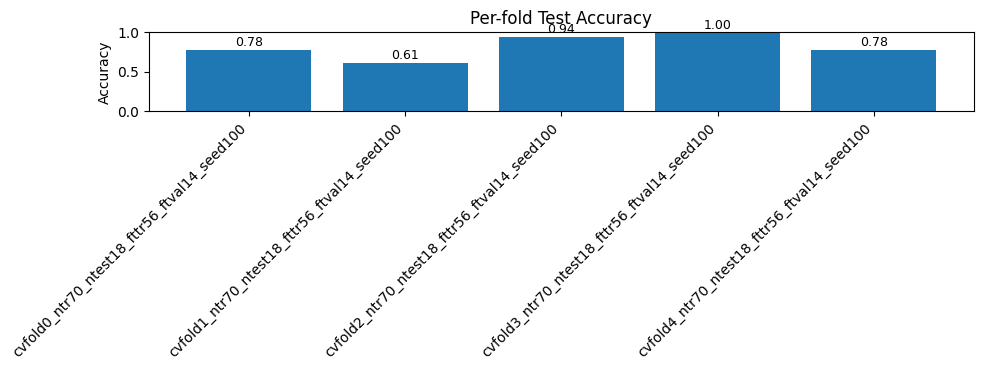

,tag,accuracy
0,cvfold0_ntr70_ntest18_fttr56_ftval14_seed100,0.777778
1,cvfold1_ntr70_ntest18_fttr56_ftval14_seed100,0.611111
2,cvfold2_ntr70_ntest18_fttr56_ftval14_seed100,0.944444
3,cvfold3_ntr70_ntest18_fttr56_ftval14_seed100,1.000000
4,cvfold4_ntr70_ntest18_fttr56_ftval14_seed100,0.777778


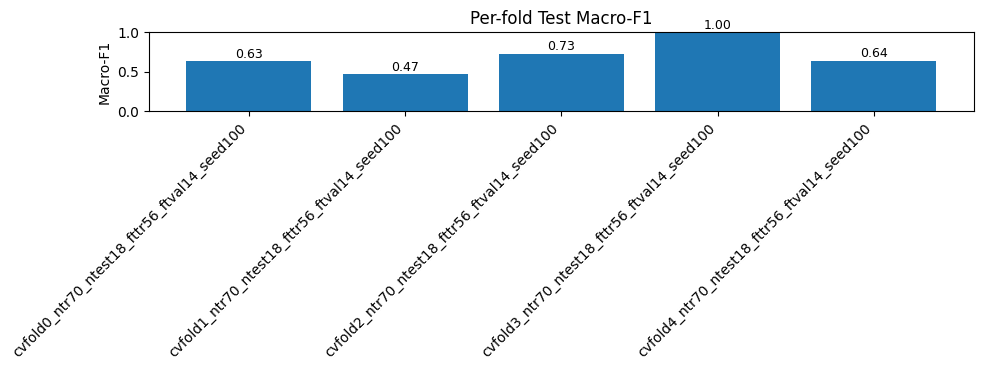

,tag,macro_f1
0,cvfold0_ntr70_ntest18_fttr56_ftval14_seed100,0.630952
1,cvfold1_ntr70_ntest18_fttr56_ftval14_seed100,0.466667
2,cvfold2_ntr70_ntest18_fttr56_ftval14_seed100,0.727273
3,cvfold3_ntr70_ntest18_fttr56_ftval14_seed100,1.000000
4,cvfold4_ntr70_ntest18_fttr56_ftval14_seed100,0.637080


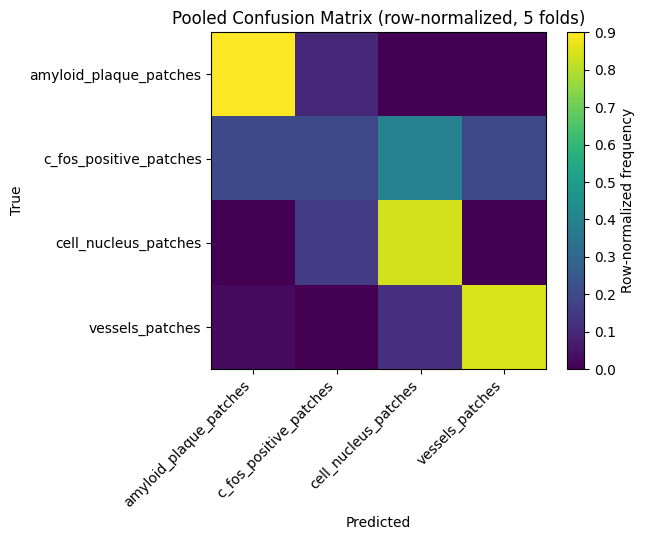

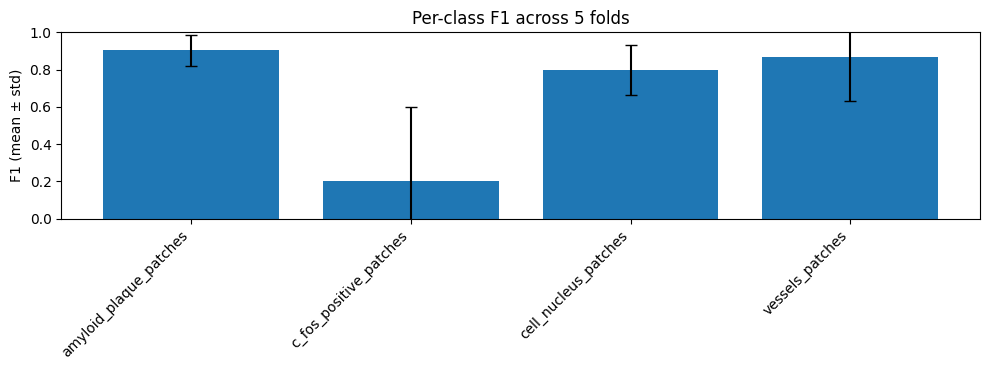

,class_name,f1_mean,f1_std
0,amyloid_plaque_patches,0.902857,0.082015
1,c_fos_positive_patches,0.200000,0.400000
2,cell_nucleus_patches,0.798485,0.134123
3,vessels_patches,0.868235,0.235223


[INFO] Folds aggregated: 5
[INFO] Accuracy mean±std: 0.8222 ± 0.1542
[INFO] Macro-F1 mean±std: 0.6924 ± 0.1960


In [1]:
# Inline visualization for 5-fold classification results
# Uses only matplotlib (no seaborn), one chart per figure, no custom colors.

import os, csv, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== YOUR PATHS ====
METRICS_ROOT = Path("/ministorage/adina/classification_eval/cls_metrics")
CLASSIFICATION_SUBDIR = "classification"
TAG_FILTER_REGEX = r"^cvfold[0-4]_ntr70_ntest18_fttr56_ftval14_seed100$"  # exact 5 folds

# ---------- Helpers ----------
def _find_tag_dirs(metrics_root: Path):
    base = metrics_root / CLASSIFICATION_SUBDIR
    if not base.exists():
        return []
    tags = []
    for tag_dir in sorted(base.iterdir()):
        if not tag_dir.is_dir():
            continue
        tag = tag_dir.name
        if TAG_FILTER_REGEX and not re.search(TAG_FILTER_REGEX, tag):
            continue
        pcm = tag_dir / f"per_class_metrics_{tag}.csv"
        cm  = tag_dir / f"confusion_matrix_{tag}.csv"
        preds = tag_dir / f"preds_{tag}.csv"  # optional
        if pcm.exists() and cm.exists():
            tags.append((tag, pcm, cm, preds if preds.exists() else None))
    return tags

def _load_overall_from_pcm(pcm_path: Path):
    rows = list(csv.reader(open(pcm_path)))
    if not rows:
        return None, None
    overall = rows[-1]
    # ["__OVERALL__", total, "ACC=0.xxxxxx", "MACRO_F1=0.xxxxxx", ""]
    try:
        acc = float(str(overall[2]).split("=")[-1])
        macro_f1 = float(str(overall[3]).split("=")[-1])
        return acc, macro_f1
    except Exception:
        return None, None

def _load_per_class_from_pcm(pcm_path: Path):
    df = pd.read_csv(pcm_path)
    return df[df["class_name"] != "__OVERALL__"][["class_name","support","precision","recall","f1_score"]].reset_index(drop=True)

def _load_cm(cm_path: Path):
    df = pd.read_csv(cm_path)
    classes = list(df.columns)[1:]
    mat = df.iloc[:, 1:].to_numpy(dtype=int)
    return classes, mat

def _row_normalize(cm: np.ndarray):
    denom = np.maximum(1, cm.sum(axis=1, keepdims=True))
    return cm.astype(float) / denom

# ---------- Load all folds ----------
tag_entries = _find_tag_dirs(METRICS_ROOT)
if not tag_entries:
    raise SystemExit(f"[ERR] No matching results under {METRICS_ROOT / CLASSIFICATION_SUBDIR}")

summary_rows = []
pooled_cm = None
classes_ref = None
per_class_f1 = {}  # class_name -> list of f1 across folds

for tag, pcm, cm, preds in tag_entries:
    acc, macro_f1 = _load_overall_from_pcm(pcm)
    if acc is None:
        continue
    summary_rows.append({"tag": tag, "accuracy": acc, "macro_f1": macro_f1})

    classes, mat = _load_cm(cm)
    if classes_ref is None:
        classes_ref = classes
        pooled_cm = mat.copy().astype(np.int64)
    else:
        assert classes == classes_ref, f"class mismatch in {cm}"
        pooled_cm += mat

    pc = _load_per_class_from_pcm(pcm)
    for _, row in pc.iterrows():
        cname = row["class_name"]
        f1 = float(row["f1_score"])
        per_class_f1.setdefault(cname, []).append(f1)

summary_df = pd.DataFrame(summary_rows).sort_values("tag").reset_index(drop=True)

# ---------- Plot: per-fold Accuracy ----------
plt.figure(figsize=(10, 3.8))
bars = plt.bar(summary_df["tag"], summary_df["accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Per-fold Test Accuracy")
plt.ylim(0, 1.0)
# annotate bars
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()
display(summary_df[["tag","accuracy"]])

# ---------- Plot: per-fold Macro-F1 ----------
plt.figure(figsize=(10, 3.8))
bars = plt.bar(summary_df["tag"], summary_df["macro_f1"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Macro-F1")
plt.title("Per-fold Test Macro-F1")
plt.ylim(0, 1.0)
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.01, f"{h:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()
display(summary_df[["tag","macro_f1"]])

# ---------- Plot: pooled confusion matrix (row-normalized) ----------
cm_norm = _row_normalize(pooled_cm)
plt.figure(figsize=(6.5, 5.5))
plt.imshow(cm_norm, aspect="auto")
plt.colorbar(label="Row-normalized frequency")
plt.xticks(ticks=range(len(classes_ref)), labels=classes_ref, rotation=45, ha="right")
plt.yticks(ticks=range(len(classes_ref)), labels=classes_ref)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Pooled Confusion Matrix (row-normalized, 5 folds)")
plt.tight_layout()
plt.show()

# ---------- Plot: per-class F1 across folds (mean ± std) ----------
class_list = sorted(per_class_f1.keys())
means = [np.mean(per_class_f1[c]) if len(per_class_f1[c]) else 0.0 for c in class_list]
stds  = [np.std(per_class_f1[c])  if len(per_class_f1[c]) else 0.0 for c in class_list]

plt.figure(figsize=(10, 3.8))
x = np.arange(len(class_list))
plt.bar(x, means, yerr=stds, capsize=4)
plt.xticks(x, class_list, rotation=45, ha="right")
plt.ylabel("F1 (mean ± std)")
plt.title("Per-class F1 across 5 folds")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

per_class_df = pd.DataFrame({"class_name": class_list, "f1_mean": means, "f1_std": stds})
display(per_class_df)

# ---------- Print quick aggregates ----------
print(f"[INFO] Folds aggregated: {len(summary_df)}")
if len(summary_df):
    print(f"[INFO] Accuracy mean±std: {summary_df['accuracy'].mean():.4f} ± {summary_df['accuracy'].std():.4f}")
    print(f"[INFO] Macro-F1 mean±std: {summary_df['macro_f1'].mean():.4f} ± {summary_df['macro_f1'].std():.4f}")


---

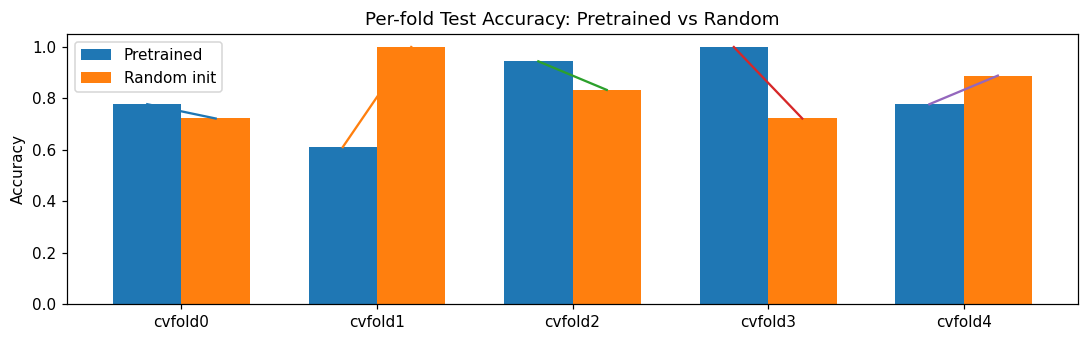

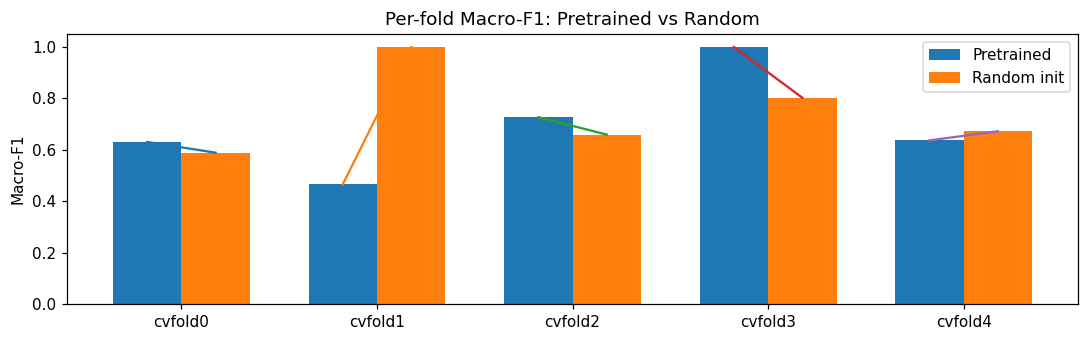

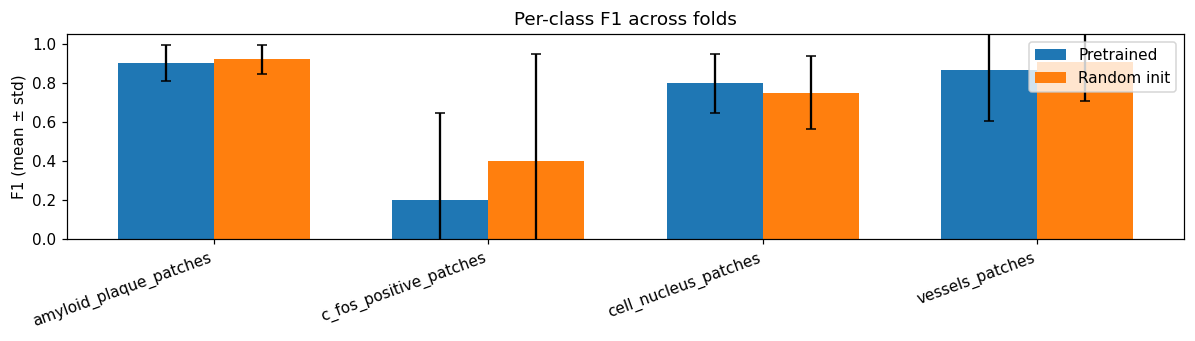

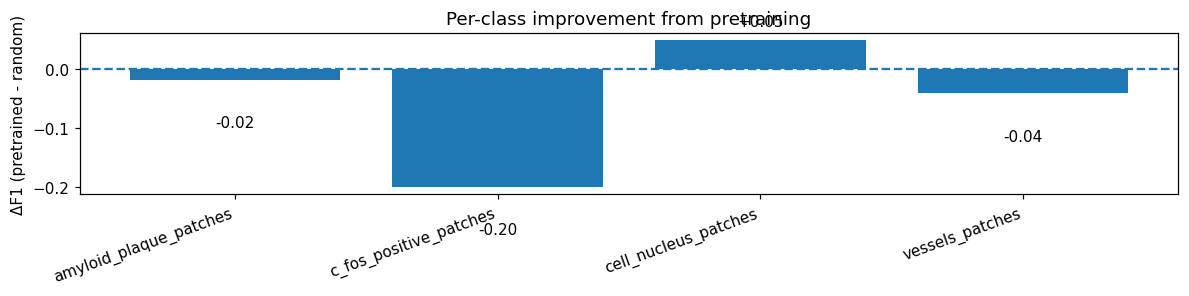

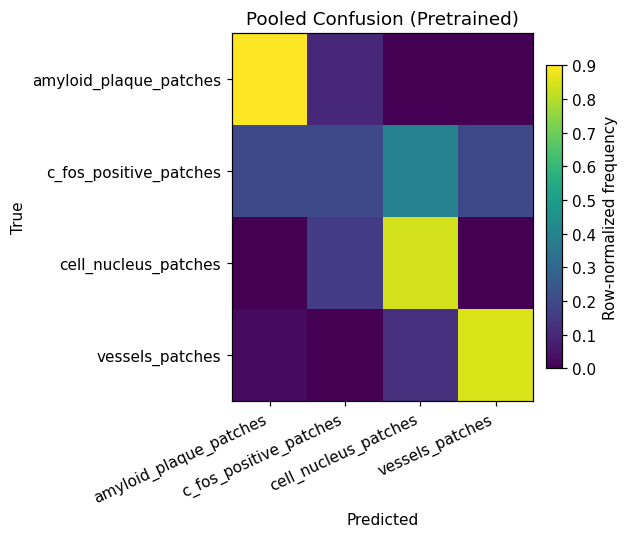

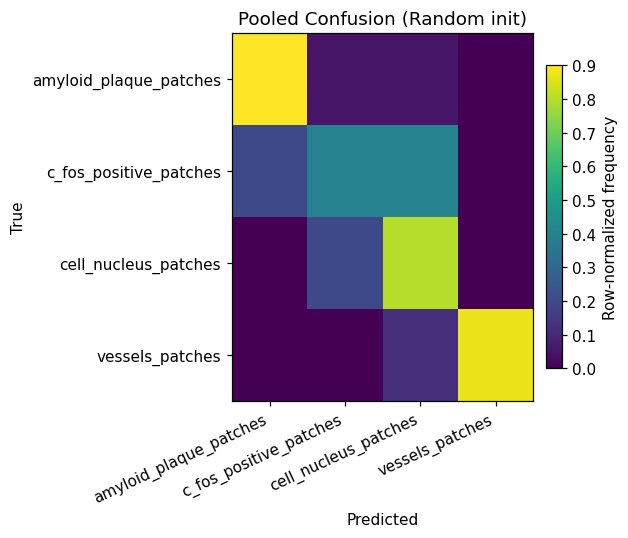


Accuracy summary:
  Pretrained: mean=0.822 ± 0.154
  Random   : mean=0.833 ± 0.118
  Δ (pre - rnd): mean=-0.011

Macro-F1 summary:
  Pretrained: mean=0.692 ± 0.196
  Random   : mean=0.745 ± 0.162
  Δ (pre - rnd): mean=-0.053


In [2]:
# === Compare pretrained vs random-init classification results across CV folds ===
# Edit these two directories to your actual outputs:
PRETRAIN_DIR = "/ministorage/adina/classification_eval/cls_metrics/classification"  # pretrained run
RANDINIT_DIR = "/ministorage/adina/classification_eval_rand/cls_metrics/classification"  # random-init run

# -------------------------------------------------------------------------------
# No seaborn; pure matplotlib as requested.
import os, re, glob, csv, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110

def _find_fold_dirs(root):
    root = Path(root)
    if not root.exists():
        return []
    # match subdirs like "cvfold0_*", "cvfold1_*", ...
    return sorted([p for p in root.iterdir() if p.is_dir() and re.search(r"cvfold\d+_", p.name)])

def _load_per_class_metrics(csv_path):
    df = pd.read_csv(csv_path)
    # Separate per-class rows and the final OVERALL row (if present)
    cls_df = df[df["class_name"] != "__OVERALL__"].copy()
    overall = None
    tail = df[df["class_name"] == "__OVERALL__"]
    if len(tail):
        # tail row has columns: class_name, support, precision(ACC=...), recall(MACRO_F1=...), f1_score(blank)
        acc = None
        macro = None
        try:
            acc = float(str(tail.iloc[0,2]).split("ACC=")[-1])
        except Exception:
            pass
        try:
            macro = float(str(tail.iloc[0,3]).split("MACRO_F1=")[-1])
        except Exception:
            pass
        overall = dict(accuracy=acc, macro_f1=macro)
    # numeric casts
    for col in ("support","precision","recall","f1_score"):
        if col in cls_df.columns:
            cls_df[col] = pd.to_numeric(cls_df[col], errors="coerce")
    return cls_df, overall

def _load_confusion(csv_path):
    # first column is header "" then class names; first column of each row is class name
    with open(csv_path, "r", newline="") as f:
        reader = list(csv.reader(f))
    header = reader[0][1:]
    rows = [r[1:] for r in reader[1:]]
    mat = np.array(rows, dtype=int)
    return header, mat

def load_run(root_dir):
    """Return:
       folds: list of fold tags
       accs: dict tag->accuracy
       macros: dict tag->macroF1
       per_cls: dict tag->DataFrame(class_name, f1_score,...)
       pooled_cm: summed confusion matrix (numpy array), class_names
    """
    accs, macros, per_cls = {}, {}, {}
    pooled_cm = None
    cm_classes = None
    folds = []

    for fd in _find_fold_dirs(root_dir):
        tag = fd.name
        # locate files
        pcs = list(fd.glob("per_class_metrics_*.csv"))
        cms = list(fd.glob("confusion_matrix_*.csv"))
        if not pcs or not cms:
            continue

        # per-class metrics
        cdf, overall = _load_per_class_metrics(pcs[0])
        per_cls[tag] = cdf
        if overall is not None:
            accs[tag] = overall["accuracy"]
            macros[tag] = overall["macro_f1"]

        # confusion matrix
        cls_names, cm = _load_confusion(cms[0])
        if pooled_cm is None:
            pooled_cm = cm.astype(np.int64)
            cm_classes = cls_names
        else:
            # ensure same class order
            if cls_names != cm_classes:
                raise ValueError(f"Class order mismatch in {fd}: {cls_names} vs {cm_classes}")
            pooled_cm += cm.astype(np.int64)

        folds.append(tag)

    folds = sorted(folds, key=lambda s: int(re.search(r"cvfold(\d+)", s).group(1)) if re.search(r"cvfold(\d+)", s) else 9999)
    return folds, accs, macros, per_cls, (cm_classes, pooled_cm)

def row_normalize(cm):
    cm = cm.astype(float)
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm.sum(axis=1, keepdims=True)
        norm = np.where(row_sums > 0, cm / row_sums, 0.0)
    return norm

def paired_tags(pre_folds, rand_folds):
    # match on "cvfoldX" prefix so we compare same fold id
    def fold_id(tag):
        m = re.search(r"cvfold(\d+)", tag)
        return int(m.group(1)) if m else None
    pf = {fold_id(t): t for t in pre_folds}
    rf = {fold_id(t): t for t in rand_folds}
    common = sorted(set(pf.keys()).intersection(rf.keys()))
    return [(pf[i], rf[i]) for i in common]

# ---- Load both runs
pre_folds, pre_acc, pre_mac, pre_cls, (pre_names, pre_cm) = load_run(PRETRAIN_DIR)
rnd_folds, rnd_acc, rnd_mac, rnd_cls, (rnd_names, rnd_cm) = load_run(RANDINIT_DIR)

if not pre_folds or not rnd_folds:
    print("[WARN] One of the result directories is empty. Check PRETRAIN_DIR / RANDINIT_DIR paths.")
else:
    if pre_names != rnd_names:
        print("[WARN] Class name order differs between runs. Plots may fail.")
    CLASS_NAMES = pre_names

    pairs = paired_tags(pre_folds, rnd_folds)
    # Build paired arrays for fold-wise comparison
    pair_labels = []
    acc_pre, acc_rnd, macro_pre, macro_rnd = [], [], [], []
    for ptag, rtag in pairs:
        pair_labels.append(re.search(r"(cvfold\d+)", ptag).group(1))
        acc_pre.append(pre_acc.get(ptag, np.nan))
        acc_rnd.append(rnd_acc.get(rtag, np.nan))
        macro_pre.append(pre_mac.get(ptag, np.nan))
        macro_rnd.append(rnd_mac.get(rtag, np.nan))

    # ---------- 1) Per-fold Accuracy (paired bars + connecting lines)
    x = np.arange(len(pair_labels))
    w = 0.35
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, acc_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, acc_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(acc_pre[i]) or np.isnan(acc_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [acc_pre[i], acc_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Per-fold Test Accuracy: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 2) Per-fold Macro-F1 (paired bars)
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, macro_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, macro_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(macro_pre[i]) or np.isnan(macro_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [macro_pre[i], macro_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Macro-F1")
    plt.title("Per-fold Macro-F1: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 3) Per-class F1 (mean ± std across folds) for each run + difference
    def stack_class_f1(per_cls_dict, class_names):
        # returns dict class -> list of f1 over folds (matching only folds that contain the class row)
        out = {c: [] for c in class_names}
        for tag, df in per_cls_dict.items():
            by = df.set_index("class_name")
            for c in class_names:
                if c in by.index and not math.isnan(by.loc[c, "f1_score"]):
                    out[c].append(float(by.loc[c, "f1_score"]))
        return out

    pre_f1_by_class = stack_class_f1(pre_cls, CLASS_NAMES)
    rnd_f1_by_class = stack_class_f1(rnd_cls, CLASS_NAMES)

    def mean_std(d):
        mu = {k: (np.mean(v) if len(v) else np.nan) for k,v in d.items()}
        sd = {k: (np.std(v, ddof=1) if len(v)>1 else 0.0) for k,v in d.items()}
        return mu, sd

    pre_mu, pre_sd = mean_std(pre_f1_by_class)
    rnd_mu, rnd_sd = mean_std(rnd_f1_by_class)

    idx = np.arange(len(CLASS_NAMES))
    fig = plt.figure(figsize=(11,3.2))
    plt.bar(idx - w/2, [pre_mu[c] for c in CLASS_NAMES], yerr=[pre_sd[c] for c in CLASS_NAMES],
            width=w, label="Pretrained", capsize=3)
    plt.bar(idx + w/2, [rnd_mu[c] for c in CLASS_NAMES], yerr=[rnd_sd[c] for c in CLASS_NAMES],
            width=w, label="Random init", capsize=3)
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylim(0, 1.05)
    plt.ylabel("F1 (mean ± std)")
    plt.title("Per-class F1 across folds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Difference plot (Pretrained - Random) per class
    diffs = [ (pre_mu[c] - rnd_mu[c]) if not (np.isnan(pre_mu[c]) or np.isnan(rnd_mu[c])) else np.nan for c in CLASS_NAMES ]
    fig = plt.figure(figsize=(11,2.8))
    bars = plt.bar(idx, diffs)
    plt.axhline(0, linestyle="--")
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylabel("ΔF1 (pretrained - random)")
    plt.title("Per-class improvement from pretraining")
    for i, d in enumerate(diffs):
        if not np.isnan(d):
            plt.text(i, d + (0.02 if d>=0 else -0.06), f"{d:+.2f}", ha="center", va="bottom" if d>=0 else "top")
    plt.tight_layout()
    plt.show()

    # ---------- 4) Pooled confusion matrices (row-normalized) for each run
    def plot_confusion(cm, class_names, title):
        cmn = row_normalize(cm)
        fig = plt.figure(figsize=(5.8,5))
        im = plt.imshow(cmn, aspect="auto")
        plt.colorbar(im, fraction=0.046, pad=0.04, label="Row-normalized frequency")
        plt.xticks(np.arange(len(class_names)), class_names, rotation=25, ha="right")
        plt.yticks(np.arange(len(class_names)), class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    plot_confusion(pre_cm, CLASS_NAMES, "Pooled Confusion (Pretrained)")
    plot_confusion(rnd_cm, CLASS_NAMES, "Pooled Confusion (Random init)")

    # ---------- 5) Short table summary printed inline
    def _summary(arr_pre, arr_rnd, label):
        pre = np.array(arr_pre, dtype=float)
        rnd = np.array(arr_rnd, dtype=float)
        print(f"\n{label} summary:")
        print(f"  Pretrained: mean={np.nanmean(pre):.3f} ± {np.nanstd(pre, ddof=1):.3f}")
        print(f"  Random   : mean={np.nanmean(rnd):.3f} ± {np.nanstd(rnd, ddof=1):.3f}")
        print(f"  Δ (pre - rnd): mean={np.nanmean(pre - rnd):.3f}")

    _summary(acc_pre, acc_rnd, "Accuracy")
    _summary(macro_pre, macro_rnd, "Macro-F1")


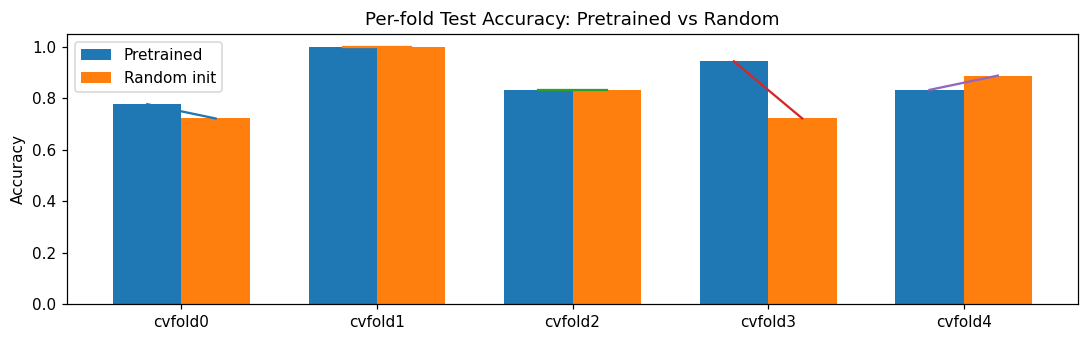

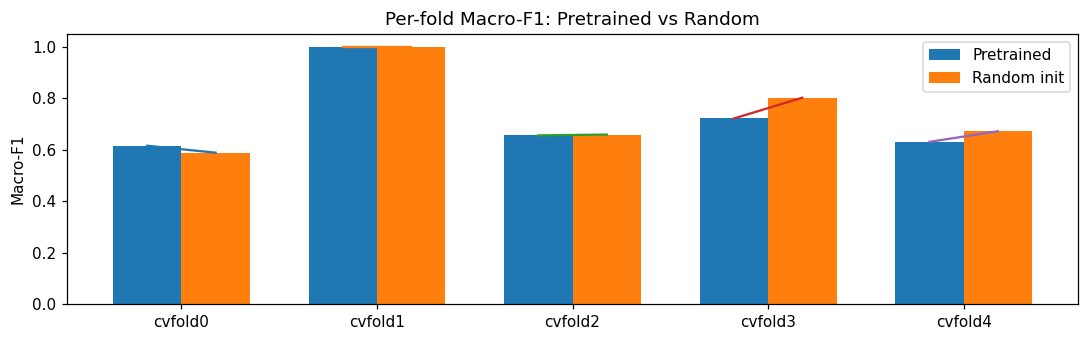

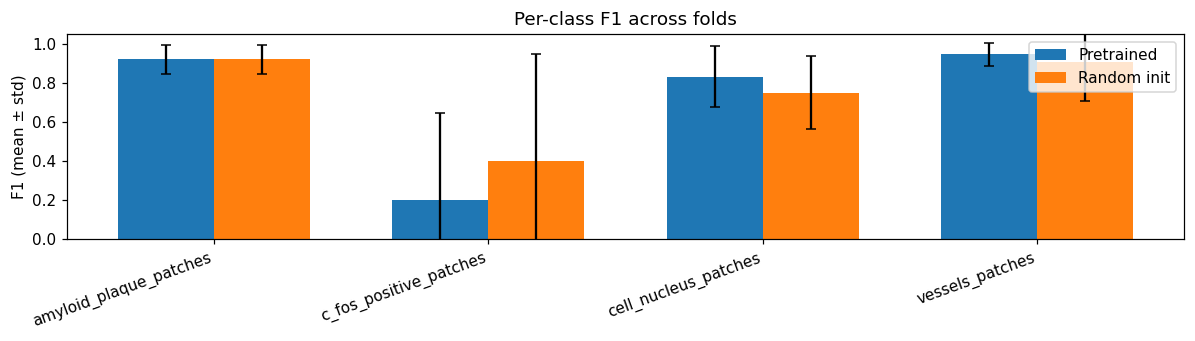

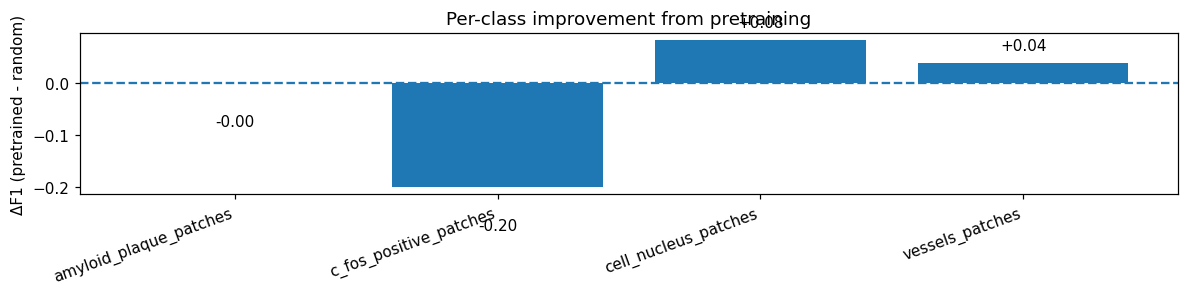

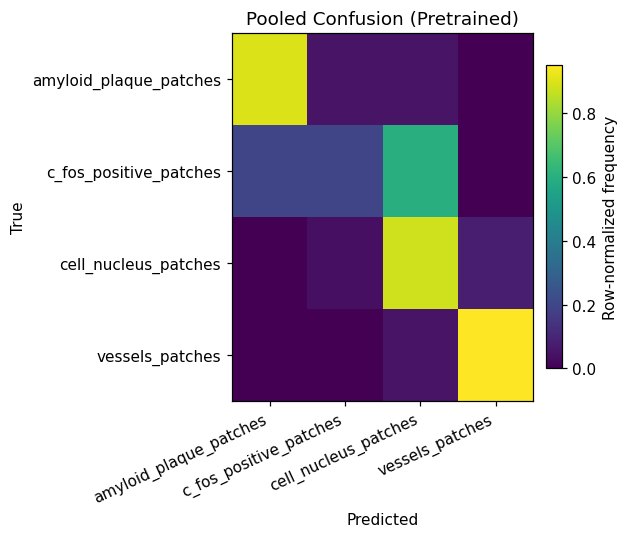

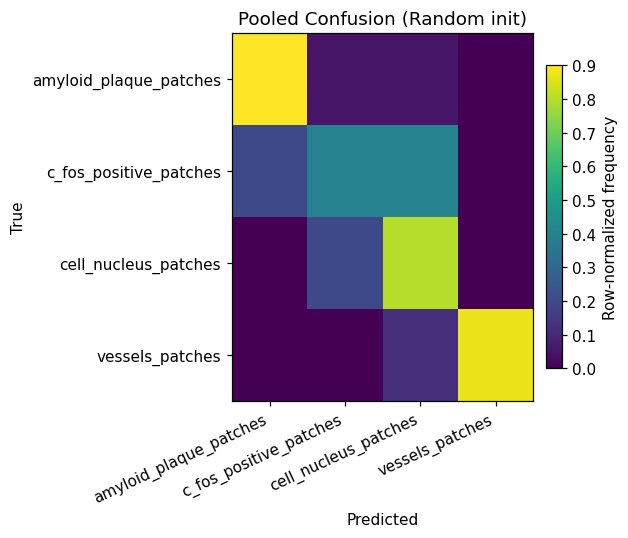


Accuracy summary:
  Pretrained: mean=0.878 ± 0.091
  Random   : mean=0.833 ± 0.118
  Δ (pre - rnd): mean=0.044

Macro-F1 summary:
  Pretrained: mean=0.725 ± 0.159
  Random   : mean=0.745 ± 0.162
  Δ (pre - rnd): mean=-0.020


In [4]:
# === Compare pretrained vs random-init classification results across CV folds ===
# Edit these two directories to your actual outputs:
PRETRAIN_DIR = "/ministorage/adina/classification_eval_image_only/cls_metrics/classification"  # pretrained run
RANDINIT_DIR = "/ministorage/adina/classification_eval_rand/cls_metrics/classification"  # random-init run

# -------------------------------------------------------------------------------
# No seaborn; pure matplotlib as requested.
import os, re, glob, csv, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110

def _find_fold_dirs(root):
    root = Path(root)
    if not root.exists():
        return []
    # match subdirs like "cvfold0_*", "cvfold1_*", ...
    return sorted([p for p in root.iterdir() if p.is_dir() and re.search(r"cvfold\d+_", p.name)])

def _load_per_class_metrics(csv_path):
    df = pd.read_csv(csv_path)
    # Separate per-class rows and the final OVERALL row (if present)
    cls_df = df[df["class_name"] != "__OVERALL__"].copy()
    overall = None
    tail = df[df["class_name"] == "__OVERALL__"]
    if len(tail):
        # tail row has columns: class_name, support, precision(ACC=...), recall(MACRO_F1=...), f1_score(blank)
        acc = None
        macro = None
        try:
            acc = float(str(tail.iloc[0,2]).split("ACC=")[-1])
        except Exception:
            pass
        try:
            macro = float(str(tail.iloc[0,3]).split("MACRO_F1=")[-1])
        except Exception:
            pass
        overall = dict(accuracy=acc, macro_f1=macro)
    # numeric casts
    for col in ("support","precision","recall","f1_score"):
        if col in cls_df.columns:
            cls_df[col] = pd.to_numeric(cls_df[col], errors="coerce")
    return cls_df, overall

def _load_confusion(csv_path):
    # first column is header "" then class names; first column of each row is class name
    with open(csv_path, "r", newline="") as f:
        reader = list(csv.reader(f))
    header = reader[0][1:]
    rows = [r[1:] for r in reader[1:]]
    mat = np.array(rows, dtype=int)
    return header, mat

def load_run(root_dir):
    """Return:
       folds: list of fold tags
       accs: dict tag->accuracy
       macros: dict tag->macroF1
       per_cls: dict tag->DataFrame(class_name, f1_score,...)
       pooled_cm: summed confusion matrix (numpy array), class_names
    """
    accs, macros, per_cls = {}, {}, {}
    pooled_cm = None
    cm_classes = None
    folds = []

    for fd in _find_fold_dirs(root_dir):
        tag = fd.name
        # locate files
        pcs = list(fd.glob("per_class_metrics_*.csv"))
        cms = list(fd.glob("confusion_matrix_*.csv"))
        if not pcs or not cms:
            continue

        # per-class metrics
        cdf, overall = _load_per_class_metrics(pcs[0])
        per_cls[tag] = cdf
        if overall is not None:
            accs[tag] = overall["accuracy"]
            macros[tag] = overall["macro_f1"]

        # confusion matrix
        cls_names, cm = _load_confusion(cms[0])
        if pooled_cm is None:
            pooled_cm = cm.astype(np.int64)
            cm_classes = cls_names
        else:
            # ensure same class order
            if cls_names != cm_classes:
                raise ValueError(f"Class order mismatch in {fd}: {cls_names} vs {cm_classes}")
            pooled_cm += cm.astype(np.int64)

        folds.append(tag)

    folds = sorted(folds, key=lambda s: int(re.search(r"cvfold(\d+)", s).group(1)) if re.search(r"cvfold(\d+)", s) else 9999)
    return folds, accs, macros, per_cls, (cm_classes, pooled_cm)

def row_normalize(cm):
    cm = cm.astype(float)
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm.sum(axis=1, keepdims=True)
        norm = np.where(row_sums > 0, cm / row_sums, 0.0)
    return norm

def paired_tags(pre_folds, rand_folds):
    # match on "cvfoldX" prefix so we compare same fold id
    def fold_id(tag):
        m = re.search(r"cvfold(\d+)", tag)
        return int(m.group(1)) if m else None
    pf = {fold_id(t): t for t in pre_folds}
    rf = {fold_id(t): t for t in rand_folds}
    common = sorted(set(pf.keys()).intersection(rf.keys()))
    return [(pf[i], rf[i]) for i in common]

# ---- Load both runs
pre_folds, pre_acc, pre_mac, pre_cls, (pre_names, pre_cm) = load_run(PRETRAIN_DIR)
rnd_folds, rnd_acc, rnd_mac, rnd_cls, (rnd_names, rnd_cm) = load_run(RANDINIT_DIR)

if not pre_folds or not rnd_folds:
    print("[WARN] One of the result directories is empty. Check PRETRAIN_DIR / RANDINIT_DIR paths.")
else:
    if pre_names != rnd_names:
        print("[WARN] Class name order differs between runs. Plots may fail.")
    CLASS_NAMES = pre_names

    pairs = paired_tags(pre_folds, rnd_folds)
    # Build paired arrays for fold-wise comparison
    pair_labels = []
    acc_pre, acc_rnd, macro_pre, macro_rnd = [], [], [], []
    for ptag, rtag in pairs:
        pair_labels.append(re.search(r"(cvfold\d+)", ptag).group(1))
        acc_pre.append(pre_acc.get(ptag, np.nan))
        acc_rnd.append(rnd_acc.get(rtag, np.nan))
        macro_pre.append(pre_mac.get(ptag, np.nan))
        macro_rnd.append(rnd_mac.get(rtag, np.nan))

    # ---------- 1) Per-fold Accuracy (paired bars + connecting lines)
    x = np.arange(len(pair_labels))
    w = 0.35
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, acc_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, acc_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(acc_pre[i]) or np.isnan(acc_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [acc_pre[i], acc_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Accuracy")
    plt.title("Per-fold Test Accuracy: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 2) Per-fold Macro-F1 (paired bars)
    fig = plt.figure(figsize=(10,3.2))
    plt.bar(x - w/2, macro_pre, width=w, label="Pretrained")
    plt.bar(x + w/2, macro_rnd, width=w, label="Random init")
    for i in range(len(x)):
        if not (np.isnan(macro_pre[i]) or np.isnan(macro_rnd[i])):
            plt.plot([x[i]-w/2, x[i]+w/2], [macro_pre[i], macro_rnd[i]])
    plt.xticks(x, pair_labels, rotation=0)
    plt.ylim(0, 1.05)
    plt.ylabel("Macro-F1")
    plt.title("Per-fold Macro-F1: Pretrained vs Random")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 3) Per-class F1 (mean ± std across folds) for each run + difference
    def stack_class_f1(per_cls_dict, class_names):
        # returns dict class -> list of f1 over folds (matching only folds that contain the class row)
        out = {c: [] for c in class_names}
        for tag, df in per_cls_dict.items():
            by = df.set_index("class_name")
            for c in class_names:
                if c in by.index and not math.isnan(by.loc[c, "f1_score"]):
                    out[c].append(float(by.loc[c, "f1_score"]))
        return out

    pre_f1_by_class = stack_class_f1(pre_cls, CLASS_NAMES)
    rnd_f1_by_class = stack_class_f1(rnd_cls, CLASS_NAMES)

    def mean_std(d):
        mu = {k: (np.mean(v) if len(v) else np.nan) for k,v in d.items()}
        sd = {k: (np.std(v, ddof=1) if len(v)>1 else 0.0) for k,v in d.items()}
        return mu, sd

    pre_mu, pre_sd = mean_std(pre_f1_by_class)
    rnd_mu, rnd_sd = mean_std(rnd_f1_by_class)

    idx = np.arange(len(CLASS_NAMES))
    fig = plt.figure(figsize=(11,3.2))
    plt.bar(idx - w/2, [pre_mu[c] for c in CLASS_NAMES], yerr=[pre_sd[c] for c in CLASS_NAMES],
            width=w, label="Pretrained", capsize=3)
    plt.bar(idx + w/2, [rnd_mu[c] for c in CLASS_NAMES], yerr=[rnd_sd[c] for c in CLASS_NAMES],
            width=w, label="Random init", capsize=3)
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylim(0, 1.05)
    plt.ylabel("F1 (mean ± std)")
    plt.title("Per-class F1 across folds")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Difference plot (Pretrained - Random) per class
    diffs = [ (pre_mu[c] - rnd_mu[c]) if not (np.isnan(pre_mu[c]) or np.isnan(rnd_mu[c])) else np.nan for c in CLASS_NAMES ]
    fig = plt.figure(figsize=(11,2.8))
    bars = plt.bar(idx, diffs)
    plt.axhline(0, linestyle="--")
    plt.xticks(idx, CLASS_NAMES, rotation=20, ha="right")
    plt.ylabel("ΔF1 (pretrained - random)")
    plt.title("Per-class improvement from pretraining")
    for i, d in enumerate(diffs):
        if not np.isnan(d):
            plt.text(i, d + (0.02 if d>=0 else -0.06), f"{d:+.2f}", ha="center", va="bottom" if d>=0 else "top")
    plt.tight_layout()
    plt.show()

    # ---------- 4) Pooled confusion matrices (row-normalized) for each run
    def plot_confusion(cm, class_names, title):
        cmn = row_normalize(cm)
        fig = plt.figure(figsize=(5.8,5))
        im = plt.imshow(cmn, aspect="auto")
        plt.colorbar(im, fraction=0.046, pad=0.04, label="Row-normalized frequency")
        plt.xticks(np.arange(len(class_names)), class_names, rotation=25, ha="right")
        plt.yticks(np.arange(len(class_names)), class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.tight_layout()
        plt.show()

    plot_confusion(pre_cm, CLASS_NAMES, "Pooled Confusion (Pretrained)")
    plot_confusion(rnd_cm, CLASS_NAMES, "Pooled Confusion (Random init)")

    # ---------- 5) Short table summary printed inline
    def _summary(arr_pre, arr_rnd, label):
        pre = np.array(arr_pre, dtype=float)
        rnd = np.array(arr_rnd, dtype=float)
        print(f"\n{label} summary:")
        print(f"  Pretrained: mean={np.nanmean(pre):.3f} ± {np.nanstd(pre, ddof=1):.3f}")
        print(f"  Random   : mean={np.nanmean(rnd):.3f} ± {np.nanstd(rnd, ddof=1):.3f}")
        print(f"  Δ (pre - rnd): mean={np.nanmean(pre - rnd):.3f}")

    _summary(acc_pre, acc_rnd, "Accuracy")
    _summary(macro_pre, macro_rnd, "Macro-F1")
